# Data exploration (Country | provincial)

In this notebook we explore the data on a country and provincial level. The purpose is to start to get a feel for the data and create some pretty cool illustrations. The notebook is made up of the following sections:
   * Time series of signups across South Africa
       * This section presents two graphs illustrating the total number of signups in SA as a function of time.
    
   * Provincial level analysis of signups across South Africa
       * This section has both Geospatial and Time series plots of the signup information wrt the provinces in SA.

In [ ]:
#Unfortunaly I did not have time to refactor this notebook into functions

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [46]:
df = pd.read_csv('data_provincial.csv')

In [48]:
df['date_column'] =  pd.to_datetime(df['date_column'])
df['province'] =  df['province'].astype(str)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           536 non-null    int64         
 1   date_column  536 non-null    datetime64[ns]
 2   city         0 non-null      float64       
 3   province     536 non-null    object        
 4   num_signups  536 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 21.1+ KB


# Time series of signups across South Africa

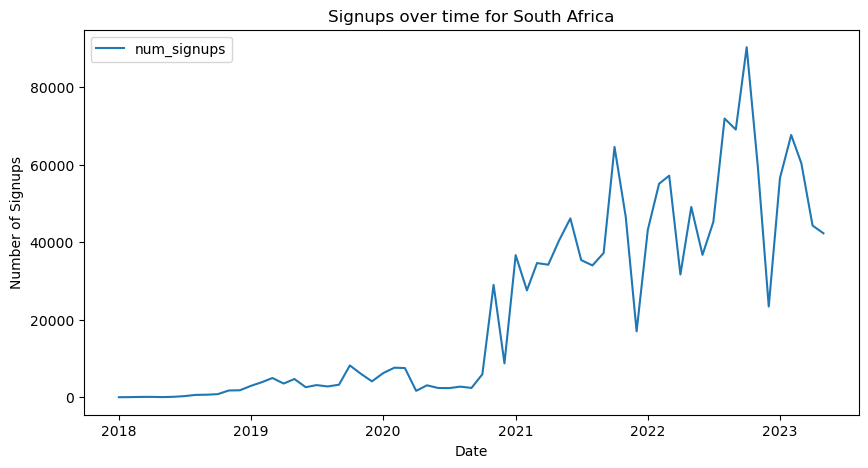

In [55]:
# Create date range
all_dates = pd.date_range(start='2018-01-01', end='2023-05-01', freq='MS')
all_dates_df = pd.DataFrame({'date_column': all_dates})


# Resample to monthly frequency and calculate sum of signups
df_monthly = df.set_index('date_column').resample('MS')['num_signups'].sum()

# Merge with complete date range
df_monthly = pd.merge(all_dates_df, df_monthly.reset_index(), on='date_column', how='left')
df_monthly.fillna(0, inplace=True)

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df_monthly['date_column'], df_monthly['num_signups'], label='num_signups')
plt.title(f'Signups over time for South Africa')
plt.xlabel('Date')
plt.ylabel('Number of Signups')
plt.legend()
plt.show()

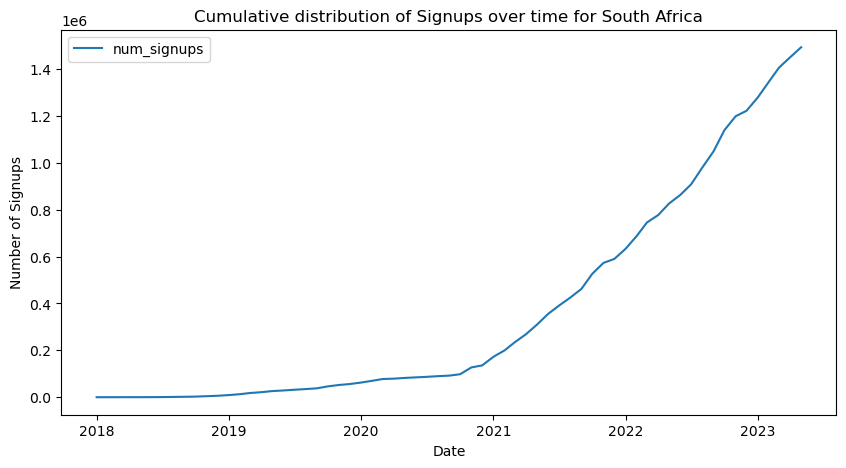

In [64]:
# Create date range
all_dates = pd.date_range(start='2018-01-01', end='2023-05-01', freq='MS')
all_dates_df = pd.DataFrame({'date_column': all_dates})


# Resample to monthly frequency and calculate sum of signups
df_monthly = df.set_index('date_column').resample('MS')['num_signups'].sum()
# Merge with complete date range
df_monthly = pd.merge(all_dates_df, df_monthly.reset_index(), on='date_column', how='left')
df_monthly.fillna(0, inplace=True)
df_monthly['cumulative_sum'] = df_monthly['num_signups'].cumsum()

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df_monthly['date_column'], df_monthly['cumulative_sum'], label='num_signups')
plt.title(f'Cumulative distribution of Signups over time for South Africa')
plt.xlabel('Date')
plt.ylabel('Number of Signups')
plt.legend()
plt.show()

# Provincial level analysis of signups across South Africa

### Geospatial plot:

In [35]:
province_coordinates = {'western cape': {'latitude': -33.822641381613636,
  'longitude': 19.22921781613346},
 'gauteng': {'latitude': -26.122987739793622, 'longitude': 28.07864420577288},
 'limpopo': {'latitude': -23.804976954095793, 'longitude': 29.773287361187393},
 'eastern cape': {'latitude': -32.26171672160452,
  'longitude': 27.411514215321315},
 'kwazulu natal': {'latitude': -29.2860586606417,
  'longitude': 30.782889075688853},
 'north west': {'latitude': -26.08671367694683,
  'longitude': 26.460329401696367},
 'free state': {'latitude': -28.279532362536372,
  'longitude': 27.25151013504369},
 'mpumalanga': {'latitude': -25.804630361098614,
  'longitude': 30.181546183524055},
 'northern cape': {'latitude': -28.909777476902164,
  'longitude': 22.919730009510886}}

In [36]:
# Create date range
all_dates = pd.date_range(start='2018-01-01', end='2023-06-01', freq='MS')
all_dates_df = pd.DataFrame({'date_column': all_dates})

# Make sure 'date_column' is datetime
df['date_column'] = pd.to_datetime(df['date_column'])

# Create an empty DataFrame to store results
df_cumulative = pd.DataFrame()

# Loop over all provinces
for province in df['province'].unique():
    df_province = df[df['province'] == province].copy()
    df_province.set_index('date_column', inplace=True)
    df_province = df_province.resample('MS')['num_signups'].sum().cumsum()  # Monthly sums
    df_province = pd.DataFrame(df_province, columns=['num_signups'])  # Recreate DataFrame with 'num_signups' column
    df_province = pd.merge(all_dates_df, df_province, on='date_column', how='left')
    df_province.fillna(0, inplace=True)
    df_province['province'] = province
    df_province['latitude'] = province_coordinates[province]['latitude']
    df_province['longitude'] = province_coordinates[province]['longitude']
    df_province.reset_index()
    df_cumulative = df_cumulative.append(df_province.reset_index())

In [37]:
df_plot = df_cumulative.copy()

In [38]:
df_plot['province'] =  df_plot['province'].astype(str)
df_plot['date_column'] =  df_plot['date_column'].astype(str)

In [39]:
fig = px.scatter_geo(df_plot,
                     lat='latitude',
                     lon='longitude',
                     color="province",
                     hover_name="province",
                     size="num_signups",
                     animation_frame="date_column",
                     projection="natural earth",
                     scope='africa',
                     title = 'Signups over time in South Africa',
                     color_continuous_scale=px.colors.sequential.Plasma,
                    size_max=100)
fig.update_layout(autosize=False, width=1100, height=900)

# Update geospatial configuration for a zoomed in view
fig.update_geos(fitbounds="locations")

fig.show()

### Time series plots

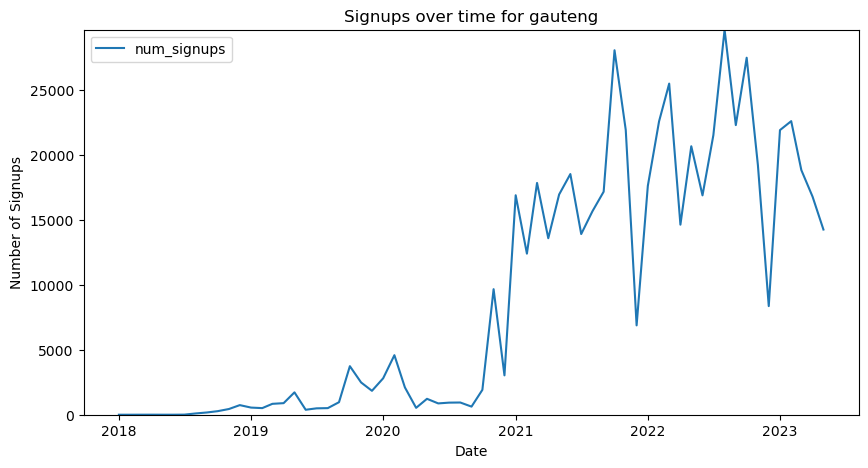

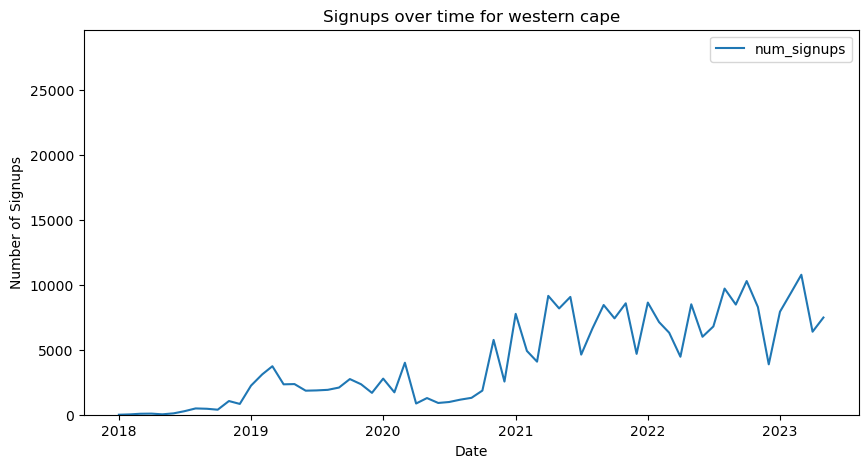

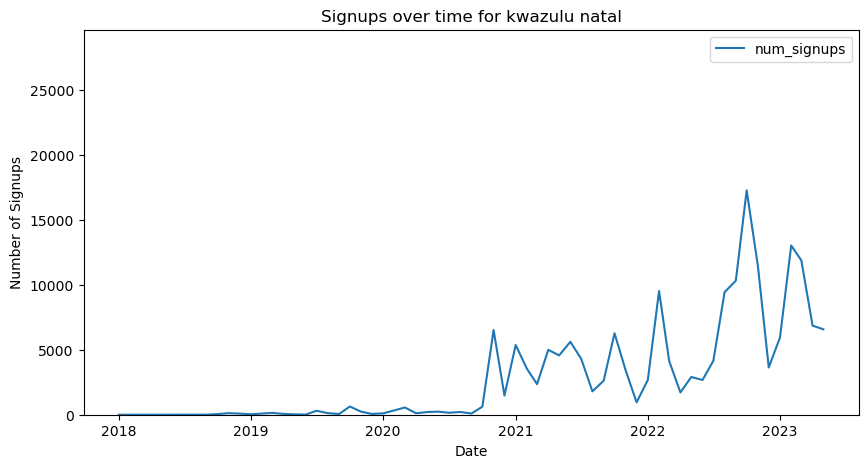

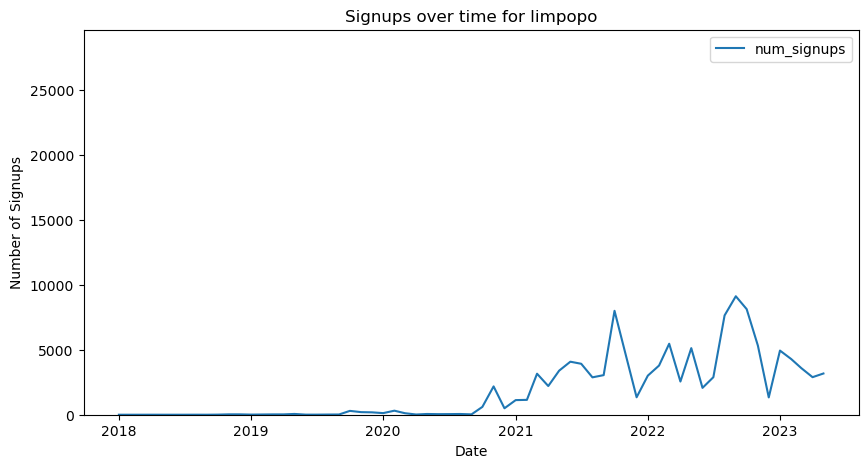

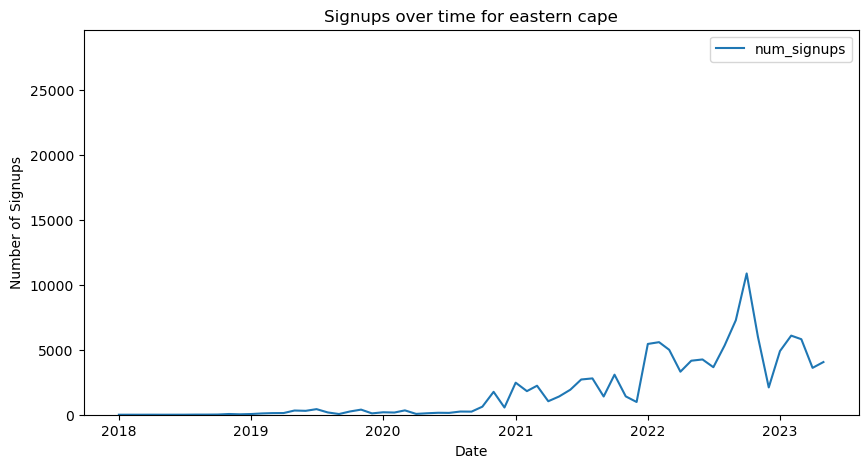

In [40]:
# Create date range
all_dates = pd.date_range(start='2018-01-01', end='2023-05-01', freq='MS')
all_dates_df = pd.DataFrame({'date_column': all_dates})

# Order provinces based on total signups
province_signups = df.groupby('province')['num_signups'].sum()
provinces_ordered = province_signups.nlargest().index

# Get maximum number of monthly signups across all provinces for y-axis limit
max_monthly_signups = df.groupby(['province', pd.Grouper(key='date_column', freq='MS')])['num_signups'].sum().max()

# Create separate plots for each province
for province in provinces_ordered:
    df_province = df[df['province'] == province]
    
    # Resample to monthly frequency and calculate sum of signups
    df_province_monthly = df_province.set_index('date_column').resample('MS')['num_signups'].sum()
    
    # Merge with complete date range
    df_province_monthly = pd.merge(all_dates_df, df_province_monthly.reset_index(), on='date_column', how='left')
    df_province_monthly.fillna(0, inplace=True)
    
    # Plot the time series
    plt.figure(figsize=(10, 5))
    plt.plot(df_province_monthly['date_column'], df_province_monthly['num_signups'], label='num_signups')
    plt.title(f'Signups over time for {province}')
    plt.xlabel('Date')
    plt.ylabel('Number of Signups')
    plt.ylim([0, max_monthly_signups])  # set the same y-axis limit for all plots
    plt.legend()
    plt.show()